In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gnn
import utils
import eval

## Edge Features

1. Player Distance

2. Speed Difference

3. Positional Sine angle

4. Positional Cosine angle

5. Velocity Sine angle

6. Velocity Cosine angle

## Node Features

1. x coordinate

2. y coordinate

3. vX

4. vY

5. Velocity

6. Velocity Angle

7. Distance to Goal

8. Angle with Goal

9. Distance to Ball

10. Angle with Ball

11. Attacking Team Flag

12. Potential Receiver


## Matrix Type

1. normal
2. delaunay
3. dense
4. dense_ap
5. dense_dp

In [1]:
! pip install spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.6 MB/s eta 0:00:00


In [2]:
! pip install livelossplot

In [3]:
from os.path import isfile
import requests
import logging
import pickle
from livelossplot import PlotLosses
import progressbar
import numpy as np
import time
import sys
from sklearn.calibration import calibration_curve
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import CrystalConv, GlobalAvgPool
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import copy
import logging
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import random
import sys
import tensorflow as tf
import requests
import progressbar
from os.path import isfile
import time

import numpy as np
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from spektral.data import DisjointLoader
from sklearn.calibration import calibration_curve

In [4]:
def get_data(file_name):
    '''
    Fetches the file from the location, loads it into memory and returns the data.
    '''
    if not isfile(file_name):
        url = f"https://ussf-ssac-23-soccer-gnn.s3.us-east-2.amazonaws.com/public/counterattack/{file_name}"

        r = requests.get(url, stream=True)
        # Fancy code to print progress bar
        block_size = 1024
        n_chunk = 1000
        file_size = int(r.headers.get('Content-Length', None))
        num_bars = np.ceil(file_size / (n_chunk * block_size))
        bar =  progressbar.ProgressBar(maxval=num_bars).start()
        with open(file_name, 'wb') as f:
            for i, chunk in enumerate(r.iter_content(chunk_size=n_chunk * block_size)):
                f.write(chunk)
                bar.update(i+1)
                # Add a little sleep so you can see the bar progress
                time.sleep(0.05)

    with open(file_name, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [5]:
def filter_features(edge_feature_idxs, node_feature_idxs, adj_matrix, data, gender=None):
    """
    gender: either None, 'm' or 'w'. Use m/w when trying out gender-aware model, this will add an extra node_feature
    the node feature will be 0 (m) and 1 (f). This is only relevent after loading both the M and W datasets (not implemented atm)
    """

    # Check for empty edge features or node features.
    if not any(edge_feature_idxs) and not any(node_feature_idxs):
        print("\nCannot have zero edge features and zero node features.\n")
        print("\nDefaulting to the previous configuration.")
    else:
        if not gender:
            data[adj_matrix]['normal_e'] = [x[:, edge_feature_idxs] for x in data[adj_matrix]['e']]
            data[adj_matrix]['normal_x'] = [x[:, node_feature_idxs] for x in data[adj_matrix]['x']]
        elif gender == 'm':
            data[adj_matrix]['normal_e'] = [x[:, edge_feature_idxs] for x in data[adj_matrix]['e']]
            data[adj_matrix]['normal_x'] = [np.append(
                x[:, node_feature_idxs],
                np.zeros(shape=(x.shape[0], 1)), axis=1
            ) for x in data[adj_matrix]['x']]
        elif gender == 'w':
            data[adj_matrix]['normal_e'] = [x[:, edge_feature_idxs] for x in data[adj_matrix]['e']]
            data[adj_matrix]['normal_x'] = [np.append(
                x[:, node_feature_idxs],
                np.ones(shape=(x.shape[0], 1)), axis=1
            ) for x in data[adj_matrix]['x']]
        else:
            raise NotImplementedError()

    return data

In [6]:
class CounterDataset(Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.data = kwargs['data']
        self.matrix_type = kwargs['matrix_type']

    def read(self):
        if self.matrix_type not in self.data:
            raise ValueError(f"Matrix type {self.matrix_type} not found in data.")
        data = self.data
        data_mat = data[self.matrix_type]
        graphs = [
            Graph(x=x, a=a, e=e, y=y) for x, a, e, y in zip(
                data_mat['x'], data_mat['a'], data_mat['e'], data['binary']
            )
        ]
        if not graphs:
            raise ValueError("No graphs could be loaded from the provided data.")

        return graphs


In [7]:
from tensorflow.keras.layers import Input, Dense, Dropout
from spektral.layers import GCNConv, GlobalAvgPool
from spektral.data import Dataset, Graph
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from spektral.layers import GlobalMaxPool
from tensorflow.keras.optimizers import Nadam

from tensorflow.keras.layers import LeakyReLU

class GCNModel(Model):
    def __init__(self, n_out, n_layers, channels, final_activation='sigmoid'):
        super().__init__()
        self.gcn_layers = [GCNConv(channels, activation=LeakyReLU(alpha=0.01)) for _ in range(n_layers)]
        self.pool = GlobalAvgPool()
        self.dense_layers = [
            Dense(channels, activation=LeakyReLU(alpha=0.01)),
            Dropout(0.5),
            Dense(n_out, activation=final_activation)
        ]

    def call(self, inputs):
        x, a, e, i = inputs
        for gcn in self.gcn_layers:
            x = gcn([x, a])
        x = self.pool([x, i])
        for dense in self.dense_layers:
            x = dense(x)
        return x


In [8]:
def create_and_train_model(data, matrix_type, learning_rate, epochs, batch_size, channels, layers):
  dataset = CounterDataset(data = data, matrix_type = matrix_type)

  N = max(g.n_nodes for g in dataset) # Number of nodes
  F = dataset.n_node_features  # Dimension of node features
  S = dataset.n_edge_features  # Dimension of edge features
  n_out = dataset.n_labels  # Dimension of the target
  n = len(dataset) # Number of samples in the dataset

  # Train/test split for the dataset
  idxs = np.random.RandomState(seed=15).permutation(len(dataset))
  split_va, split_te = int(0.7 * len(dataset)), int(0.69 * len(dataset))
  idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
  dataset_tr = dataset[idx_tr]
  dataset_te = dataset[idx_te]
 # When creating the loader, check if you need to adjust batch format
  loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
  loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1, shuffle=False)


  model = GCNModel(n_out, n_layers=layers, channels=channels)  # Adjust parameters as necessary
  optimizer = Nadam(learning_rate=learning_rate)
  loss_fn = BinaryCrossentropy()

  # Initialize the live loss plot instance
  live_plot = PlotLosses()

  # Initialize tracking variables
  step = 0
  cumulative_loss = 0

  @tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
  def train_step(inputs, target):
      with tf.GradientTape() as tape:
          predictions = model(inputs, training=True)  # Pass inputs directly
          loss = loss_fn(target, predictions) + sum(model.losses)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      return loss




  # Print loss at each step of training.
  step = loss = 0
  for batch in loader_tr:
      step += 1
      loss += train_step(*batch)
      if step == loader_tr.steps_per_epoch:
          step = 0
          print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
          loss = 0

  return loader_tr, loader_te, model

In [9]:
def roc_auc(loader_te,model):
  y_true = []
  y_pred = []

  # Add the true values and the predicted values in the list
  for batch in loader_te:
      inputs, target = batch
      p = model(inputs, training=False)
      y_true.append(target)
      y_pred.append(p.numpy())

  # Calculate the ROC-AUC metric
  y_true = np.vstack(y_true)
  y_pred = np.vstack(y_pred)

  # Assuming y_true and y_pred are defined and populated as before

  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  roc_auc = metrics.auc(fpr, tpr)

  sns.set(style="whitegrid")  # Use seaborn style for more polished aesthetics

  plt.figure(figsize=(8, 6), dpi=300)  # Opt for a sensible DPI
  plt.plot(fpr, tpr, color='magenta', lw=2, label='AUC = %0.2f' % roc_auc, marker='*', markersize=6)  # Vibrant color & markers
  plt.fill_between(fpr, tpr, color='lavender', alpha=0.4)  # Complementary fill color
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Differentiate diagonal line

  # Enhance labels and title aesthetics
  plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
  plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
  plt.title('Receiver Operating Characteristic', fontsize=16, fontweight='bold')
  plt.legend(loc='lower right', fontsize=12)

  # Refine tick marks and grid for better readability
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')

  plt.tight_layout()
  plt.show()

  return roc_auc

In [10]:
def ece(data, matrix_type, model):
  # Reload the dataset in the CounterDataset format.
  dataset_c = CounterDataset(data=data, matrix_type = matrix_type)

  # Setup the loader.
  loader = DisjointLoader(dataset_c, batch_size=1, epochs=1, shuffle = False)

  # Set up an empty pandas dataframe.
  ece_df = pd.DataFrame(columns = ['output_pp', 'predicted', 'target', 'result'])

  # Compute the predictions and save them in the Pandas DataFrame.
  for batch in loader:
      inputs, target = batch
      p = model(inputs, training=False)
      original_prediction = p.numpy()[0][0]

      # Threshold set to 0.5
      predicted_value = 1 if original_prediction >= 0.5 else 0
      ece_df.loc[len(ece_df)] = [original_prediction, predicted_value, target[0][0], 1 if predicted_value == target[0][0] else 0]

  # Setting up the bins
  bin_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
  bin_calc = pd.DataFrame(columns = ['bin', 'count', 'accuracy', 'avg_pp', 'acc-conf', 'count_into_acc-conf'])

  for i, bin_range in enumerate(bin_ranges):
      # Get the higher and lower end of the bins
      lower, higher = bin_range[0], bin_range[1]

      # Get the probability outputs within the range
      bin_calc_temp = ece_df.loc[(ece_df['output_pp'] > lower) & (ece_df['output_pp'] <= higher)]
      count = bin_calc_temp.shape[0]

      # Compute parameters needed to calculate ECE
      if count > 0:
          total_corrects = bin_calc_temp[(bin_calc_temp['result'] == 1)].shape[0]
          accuracy = total_corrects / count
          avg_pp = bin_calc_temp['output_pp'].mean()
          acc_conf = abs(accuracy - avg_pp)

          bin_calc.loc[i] = [bin_range, count, accuracy, avg_pp, acc_conf, count*acc_conf]

  # Print ECE value
  print("ECE is : " + str(bin_calc['count_into_acc-conf'].sum() / bin_calc['count'].sum()))

  cal_y, cal_x = calibration_curve(ece_df['target'], ece_df['output_pp'], n_bins=10)

  sns.set_style("whitegrid")  # Use seaborn style for a cleaner background and grid

  fig, ax = plt.subplots(figsize=(10, 7))  # Slightly larger figure size for better detail visibility
  # Plot the calibration curve with aesthetic improvements
  plt.plot(cal_x, cal_y, marker='o', markersize=12, linestyle='-', linewidth=3, color='royalblue', label='Model Calibration')
  plt.plot([0, 1], [0, 1], ls='--', color='darkorange', linewidth=2, label='Ideal Calibration')
  plt.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white', edgecolor='black')
  plt.xlabel('Average Predicted Probability in Each Bin', fontsize=14, fontweight='bold')
  plt.ylabel('Ratio of Positives', fontsize=14, fontweight='bold')
  plt.title("Calibration Curve", fontsize=16, fontweight='bold')
  plt.grid(True, which='both', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)  # Enhanced grid visibility
  plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.5)  # Add minor grid lines
  plt.minorticks_on()  # Enable minor ticks
  plt.tight_layout()
  plt.show()

  return bin_calc['count_into_acc-conf'].sum() / bin_calc['count'].sum()

In [24]:
og_data = get_data("combined.pkl")

edge_feature = [0,1,2,5]
node_feature = [11,7,8,6,4,3,2,0]
matrix_type = "dense"
data_flt = filter_features(edge_feature,node_feature,matrix_type,og_data.copy())

100% (2429 of 2429.0) |##################| Elapsed Time: 0:02:11 ETA:  00:00:00

In [25]:
learning_rate = 5e-5
epochs = 300
batch_size = 16
channels = 128
layers = 3

In [26]:
loader_tr, loader_te, model = create_and_train_model(data_flt, matrix_type, learning_rate, epochs, batch_size, channels, layers)

/usr/local/lib/python3.10/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'CounterDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 110.14266204833984
Loss: 8.20976734161377
Loss: 2.8879127502441406
Loss: 2.31067156791687
Loss: 1.982018232345581
Loss: 1.8070037364959717
Loss: 1.6211094856262207
Loss: 1.4726195335388184
Loss: 1.32781183719635
Loss: 1.2357878684997559
Loss: 1.1380747556686401
Loss: 1.0633649826049805
Loss: 0.9875016808509827
Loss: 0.9358013272285461
Loss: 0.8962376713752747
Loss: 0.8436415195465088
Loss: 0.8119013905525208
Loss: 0.7863601446151733
Loss: 0.7805278301239014
Loss: 0.7466674447059631
Loss: 0.7285924553871155
Loss: 0.7225369811058044
Loss: 0.707425057888031
Loss: 0.6968602538108826
Loss: 0.6881281733512878
Loss: 0.6859591603279114
Loss: 0.6779834628105164
Loss: 0.6760613918304443
Loss: 0.6682869791984558
Loss: 0.6684963703155518
Loss: 0.6616306304931641
Loss: 0.6592514514923096
Loss: 0.6542143225669861
Loss: 0.6539168357849121
Loss: 0.6502066850662231
Loss: 0.6504828333854675
Loss: 0.6482335925102234
Loss: 0.6452551484107971
Loss: 0.6458303332328796
Loss: 0.6436076164245605
Loss: 0.

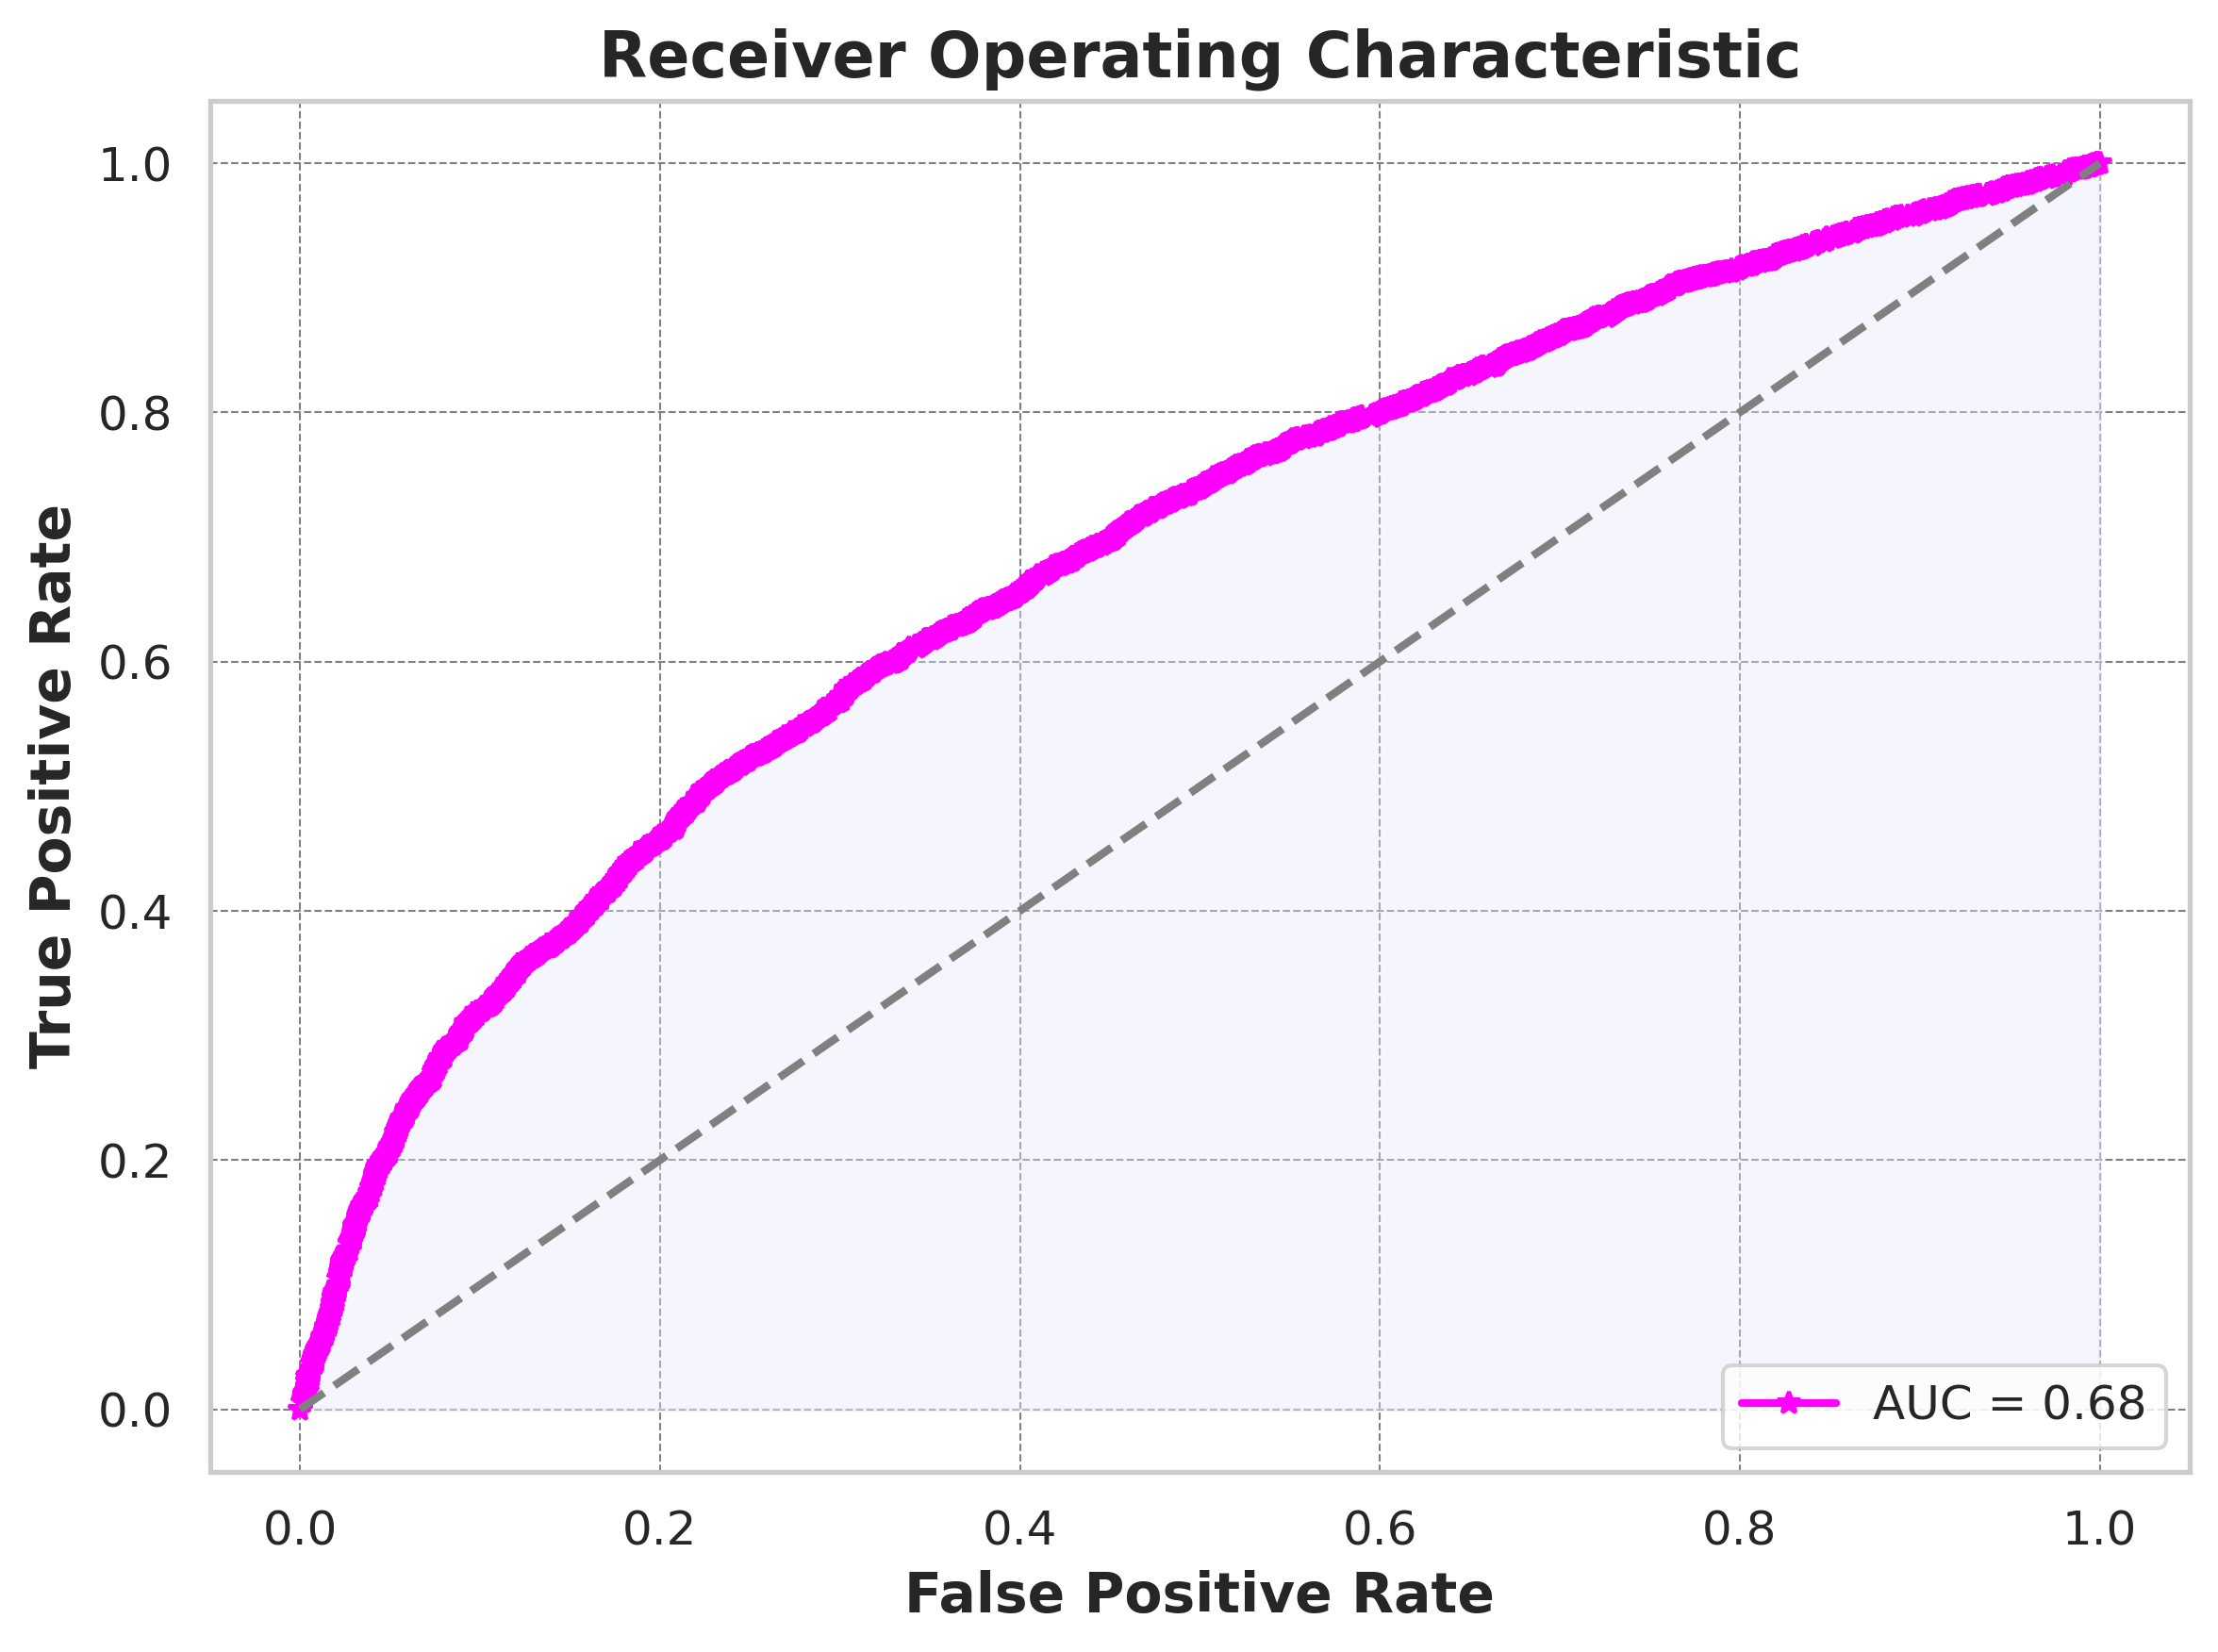

0.6835330135087077

In [27]:
roc_auc(loader_te,model)

In [ ]:
ece(data_flt, matrix_type, model)